# Vision-nanoGPT:

## 1. Setting Up and Data Loading

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import torchvision
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
import numpy as np
from tqdm.notebook import tqdm
import math
import os

# Set device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

# Create CombinedMNISTDataset
class CombinedMNISTDataset(Dataset):
    def __init__(self, root='./data', train=True, transform=None, download=True):
        self.transform = transform

        # Get MNIST
        mnist = datasets.MNIST(root=root, train=train, download=download, transform=None)

        # Get FashionMNIST
        fashion_mnist = datasets.FashionMNIST(root=root, train=train, download=download, transform=None)

        # Combine data
        self.data = torch.cat([
            mnist.data.unsqueeze(1).float() / 255.0,  # Add channel dimension
            fashion_mnist.data.unsqueeze(1).float() / 255.0
        ])

        # Combine targets (FashionMNIST labels offset by 10)
        self.targets = torch.cat([
            mnist.targets,
            fashion_mnist.targets + 10
        ])

        # Class names
        self.class_names = [
            '0', '1', '2', '3', '4', '5', '6', '7', '8', '9',  # MNIST
            'T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',  # FashionMNIST
            'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot'
        ]

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        img, target = self.data[idx], int(self.targets[idx])

        if self.transform:
            img = self.transform(img)

        return img, target

Using device: cuda


## 2. Data Preprocessing and Loading

100%|██████████| 9.91M/9.91M [00:00<00:00, 17.9MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 484kB/s]
100%|██████████| 1.65M/1.65M [00:00<00:00, 4.44MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 6.81MB/s]
100%|██████████| 26.4M/26.4M [00:01<00:00, 13.9MB/s]
100%|██████████| 29.5k/29.5k [00:00<00:00, 209kB/s]
100%|██████████| 4.42M/4.42M [00:01<00:00, 3.88MB/s]
100%|██████████| 5.15k/5.15k [00:00<00:00, 9.90MB/s]


Training samples: 120000
Validation samples: 20000
Number of classes: 20


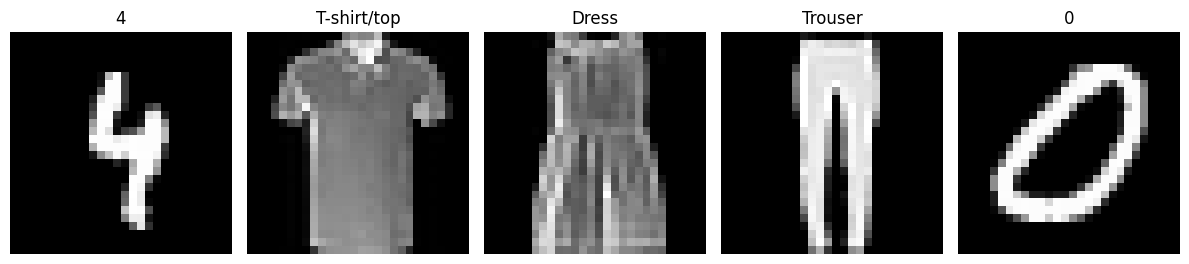

In [ ]:
# Define transforms
train_transform = transforms.Compose([
    transforms.Normalize((0.5,), (0.5,))
])

val_transform = transforms.Compose([
    transforms.Normalize((0.5,), (0.5,))
])

# Create datasets
train_dataset = CombinedMNISTDataset(train=True, transform=train_transform)
val_dataset = CombinedMNISTDataset(train=False, transform=val_transform)

# Create dataloaders
batch_size = 64
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=2)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=2)

# Get class names
class_names = train_dataset.class_names

# Display basic info
print(f"Training samples: {len(train_dataset)}")
print(f"Validation samples: {len(val_dataset)}")
print(f"Number of classes: {len(class_names)}")

# Visualize samples
def show_samples(dataloader, n=5):
    data_iter = iter(dataloader)
    images, labels = next(data_iter)

    fig, axes = plt.subplots(1, n, figsize=(12, 3))
    for i in range(n):
        img = images[i].squeeze().numpy()
        label = labels[i].item()
        axes[i].imshow(img, cmap='gray')
        axes[i].set_title(f"{class_names[label]}")
        axes[i].axis('off')
    plt.tight_layout()
    plt.show()

show_samples(train_loader)

## 3. Model Architecture

In [ ]:
class LayerNorm(nn.Module):
    def __init__(self, ndim, bias=True):
        super().__init__()
        self.weight = nn.Parameter(torch.ones(ndim))
        self.bias = nn.Parameter(torch.zeros(ndim)) if bias else None

    def forward(self, x):
        return F.layer_norm(x, self.weight.shape, self.weight, self.bias, 1e-5)

class PatchEmbedding(nn.Module):
    def __init__(self, img_size=28, patch_size=4, in_channels=1, embed_dim=256):
        super().__init__()
        self.img_size = img_size
        self.patch_size = patch_size
        self.n_patches = (img_size // patch_size) ** 2

        # Patch to embedding projection
        self.proj = nn.Conv2d(in_channels, embed_dim, kernel_size=patch_size, stride=patch_size)

        # CLS token
        self.cls_token = nn.Parameter(torch.zeros(1, 1, embed_dim))

        # Position embedding
        self.pos_embed = nn.Parameter(torch.zeros(1, self.n_patches + 1, embed_dim))
        nn.init.normal_(self.pos_embed, std=0.02)

    def forward(self, x):
        B = x.shape[0]

        # Project patches
        x = self.proj(x)
        x = x.flatten(2)
        x = x.transpose(1, 2)

        # Add CLS token
        cls_tokens = self.cls_token.expand(B, -1, -1)
        x = torch.cat((cls_tokens, x), dim=1)

        # Add position embedding
        x = x + self.pos_embed

        return x

class MultiHeadAttention(nn.Module):
    def __init__(self, config):
        super().__init__()
        assert config.n_embd % config.n_head == 0

        # Key, query, value projections
        self.c_attn = nn.Linear(config.n_embd, 3 * config.n_embd, bias=config.bias)

        # Output projection
        self.c_proj = nn.Linear(config.n_embd, config.n_embd, bias=config.bias)

        # Regularization
        self.attn_dropout = nn.Dropout(config.dropout)
        self.resid_dropout = nn.Dropout(config.dropout)

        # Dimensions
        self.n_head = config.n_head
        self.n_embd = config.n_embd
        self.head_dim = config.n_embd // config.n_head
        self.dropout = config.dropout

        # Flash attention
        self.flash = hasattr(torch.nn.functional, 'scaled_dot_product_attention')

    def forward(self, x):
        B, T, C = x.size()

        # Calculate query, key, values
        qkv = self.c_attn(x)
        q, k, v = qkv.chunk(3, dim=-1)

        # Reshape for multi-head attention
        q = q.view(B, T, self.n_head, self.head_dim).transpose(1, 2)
        k = k.view(B, T, self.n_head, self.head_dim).transpose(1, 2)
        v = v.view(B, T, self.n_head, self.head_dim).transpose(1, 2)

        # Compute attention
        if self.flash:
            y = torch.nn.functional.scaled_dot_product_attention(
                q, k, v,
                attn_mask=None,
                dropout_p=self.dropout if self.training else 0,
                is_causal=False
            )
        else:
            att = (q @ k.transpose(-2, -1)) * (1.0 / math.sqrt(k.size(-1)))
            att = F.softmax(att, dim=-1)
            att = self.attn_dropout(att)
            y = att @ v

        # Reshape and project back
        y = y.transpose(1, 2).contiguous().view(B, T, C)
        y = self.resid_dropout(self.c_proj(y))

        return y

class FeedForward(nn.Module):
    def __init__(self, config):
        super().__init__()
        self.c_fc = nn.Linear(config.n_embd, 4 * config.n_embd, bias=config.bias)
        self.gelu = nn.GELU()
        self.c_proj = nn.Linear(4 * config.n_embd, config.n_embd, bias=config.bias)
        self.dropout = nn.Dropout(config.dropout)

    def forward(self, x):
        x = self.c_fc(x)
        x = self.gelu(x)
        x = self.c_proj(x)
        x = self.dropout(x)
        return x

class Block(nn.Module):
    def __init__(self, config):
        super().__init__()
        self.ln_1 = LayerNorm(config.n_embd, bias=config.bias)
        self.attn = MultiHeadAttention(config)
        self.ln_2 = LayerNorm(config.n_embd, bias=config.bias)
        self.mlp = FeedForward(config)

    def forward(self, x):
        x = x + self.attn(self.ln_1(x))
        x = x + self.mlp(self.ln_2(x))
        return x

class VisionGPTConfig:
    def __init__(self, **kwargs):
        self.img_size = 28
        self.patch_size = 4
        self.in_channels = 1
        self.n_layer = 6
        self.n_head = 8
        self.n_embd = 256
        self.dropout = 0.1
        self.bias = True
        self.n_classes = 20

        # Calculate block_size
        self.block_size = (self.img_size // self.patch_size) ** 2 + 1  # +1 for cls token

        # Override defaults with kwargs
        for k, v in kwargs.items():
            setattr(self, k, v)

class VisionGPT(nn.Module):
    def __init__(self, config):
        super().__init__()
        self.config = config

        # Patch embedding
        self.patch_embed = PatchEmbedding(
            img_size=config.img_size,
            patch_size=config.patch_size,
            in_channels=config.in_channels,
            embed_dim=config.n_embd
        )

        # Dropout
        self.drop = nn.Dropout(config.dropout)

        # Transformer blocks
        self.blocks = nn.ModuleList([Block(config) for _ in range(config.n_layer)])

        # Final layer norm
        self.ln_f = LayerNorm(config.n_embd, bias=config.bias)

        # Classification head
        self.head = nn.Linear(config.n_embd, config.n_classes, bias=False)

        # Initialize weights
        self.apply(self._init_weights)

        # Special init for projection layers
        for pn, p in self.named_parameters():
            if pn.endswith('c_proj.weight'):
                torch.nn.init.normal_(p, mean=0.0, std=0.02/math.sqrt(2 * config.n_layer))

        # Report number of parameters
        print(f"Number of parameters: {self.get_num_params()/1e6:.2f}M")

    def get_num_params(self):
        return sum(p.numel() for p in self.parameters())

    def _init_weights(self, module):
        if isinstance(module, nn.Linear):
            torch.nn.init.normal_(module.weight, mean=0.0, std=0.02)
            if module.bias is not None:
                torch.nn.init.zeros_(module.bias)
        elif isinstance(module, nn.Embedding):
            torch.nn.init.normal_(module.weight, mean=0.0, std=0.02)
        elif isinstance(module, nn.LayerNorm):
            torch.nn.init.zeros_(module.bias)
            torch.nn.init.ones_(module.weight)

    def forward(self, x, targets=None):
        # Get patch embeddings
        x = self.patch_embed(x)

        # Apply dropout
        x = self.drop(x)

        # Apply transformer blocks
        for block in self.blocks:
            x = block(x)

        # Apply final layer norm
        x = self.ln_f(x)

        # Classification using CLS token
        logits = self.head(x[:, 0])

        # Calculate loss if targets provided
        loss = None
        if targets is not None:
            loss = F.cross_entropy(logits, targets)

        return logits, loss

## 4. Model Initialization

In [ ]:
# Initialize model
config = VisionGPTConfig()
model = VisionGPT(config).to(device)

# Set optimizer
optimizer = torch.optim.AdamW(
    model.parameters(),
    lr=3e-4,
    weight_decay=0.01,
    betas=(0.9, 0.95)
)

# Set learning rate scheduler
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(
    optimizer,
    T_max=5000,
    eta_min=3e-5
)

Number of parameters: 4.76M


## 5. Training and Evaluation Functions

In [ ]:
# Evaluation function
@torch.no_grad()
def evaluate(model, dataloader, device):
    model.eval()
    total_loss = 0
    correct = 0
    total = 0

    for images, targets in dataloader:
        images, targets = images.to(device), targets.to(device)

        # Forward pass
        logits, loss = model(images, targets)

        # Calculate metrics
        total_loss += loss.item() * images.size(0)
        _, predicted = logits.max(1)
        total += targets.size(0)
        correct += predicted.eq(targets).sum().item()

    # Calculate final metrics
    avg_loss = total_loss / total
    accuracy = 100 * correct / total

    return avg_loss, accuracy

# Training loop
def train(model, train_loader, val_loader, optimizer, scheduler, device, epochs=5):
    best_val_acc = 0
    train_losses = []
    val_losses = []
    train_accs = []
    val_accs = []

    # Create directory for checkpoints
    os.makedirs('checkpoints', exist_ok=True)

    for epoch in range(epochs):
        model.train()
        train_loss = 0
        correct = 0
        total = 0

        pbar = tqdm(train_loader)
        for images, targets in pbar:
            images, targets = images.to(device), targets.to(device)

            # Forward pass
            optimizer.zero_grad()
            logits, loss = model(images, targets)

            # Backward pass
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
            optimizer.step()
            scheduler.step()

            # Update metrics
            train_loss += loss.item() * images.size(0)
            _, predicted = logits.max(1)
            total += targets.size(0)
            correct += predicted.eq(targets).sum().item()

            # Update progress bar
            pbar.set_description(f"Epoch {epoch+1} | Loss: {loss.item():.4f}")

        # Calculate epoch metrics
        epoch_loss = train_loss / total
        epoch_acc = 100 * correct / total
        train_losses.append(epoch_loss)
        train_accs.append(epoch_acc)

        # Evaluate on validation set
        val_loss, val_acc = evaluate(model, val_loader, device)
        val_losses.append(val_loss)
        val_accs.append(val_acc)

        # Print metrics
        print(f"Epoch {epoch+1}/{epochs}:")
        print(f"  Train Loss: {epoch_loss:.4f}, Train Acc: {epoch_acc:.2f}%")
        print(f"  Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.2f}%")

        # Save best model
        if val_acc > best_val_acc:
            best_val_acc = val_acc
            torch.save({
                'epoch': epoch,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'scheduler_state_dict': scheduler.state_dict(),
                'val_acc': val_acc,
            }, f'checkpoints/best_model.pt')
            print(f"  New best model saved with val acc: {val_acc:.2f}%")

    # Return training history
    return {
        'train_losses': train_losses,
        'val_losses': val_losses,
        'train_accs': train_accs,
        'val_accs': val_accs,
    }

In [ ]:
## 6. Train the Model

In [ ]:
# Train the model
epochs = 5
history = train(model, train_loader, val_loader, optimizer, scheduler, device, epochs)

  0%|          | 0/1875 [00:00<?, ?it/s]

Epoch 1/5:
  Train Loss: 0.8727, Train Acc: 69.33%
  Val Loss: 0.4331, Val Acc: 85.04%
  New best model saved with val acc: 85.04%


  0%|          | 0/1875 [00:00<?, ?it/s]

Epoch 2/5:
  Train Loss: 0.3454, Train Acc: 87.95%
  Val Loss: 0.2691, Val Acc: 90.44%
  New best model saved with val acc: 90.44%


  0%|          | 0/1875 [00:00<?, ?it/s]

Epoch 3/5:
  Train Loss: 0.2535, Train Acc: 91.04%
  Val Loss: 0.2437, Val Acc: 91.25%
  New best model saved with val acc: 91.25%


  0%|          | 0/1875 [00:00<?, ?it/s]

Epoch 4/5:
  Train Loss: 0.2611, Train Acc: 90.84%
  Val Loss: 0.3024, Val Acc: 89.44%


  0%|          | 0/1875 [00:00<?, ?it/s]

Epoch 5/5:
  Train Loss: 0.3023, Train Acc: 89.36%
  Val Loss: 0.2901, Val Acc: 89.81%


## 7. Evaluation and Visualization

Loaded best model from epoch 3 with val acc: 91.25%
Final evaluation: Loss: 0.2437, Accuracy: 91.25%


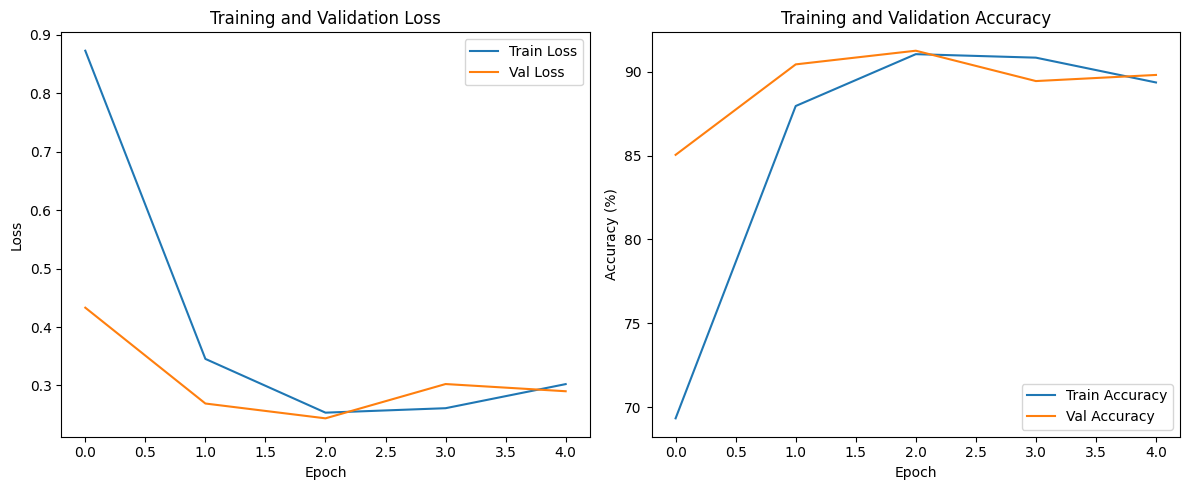

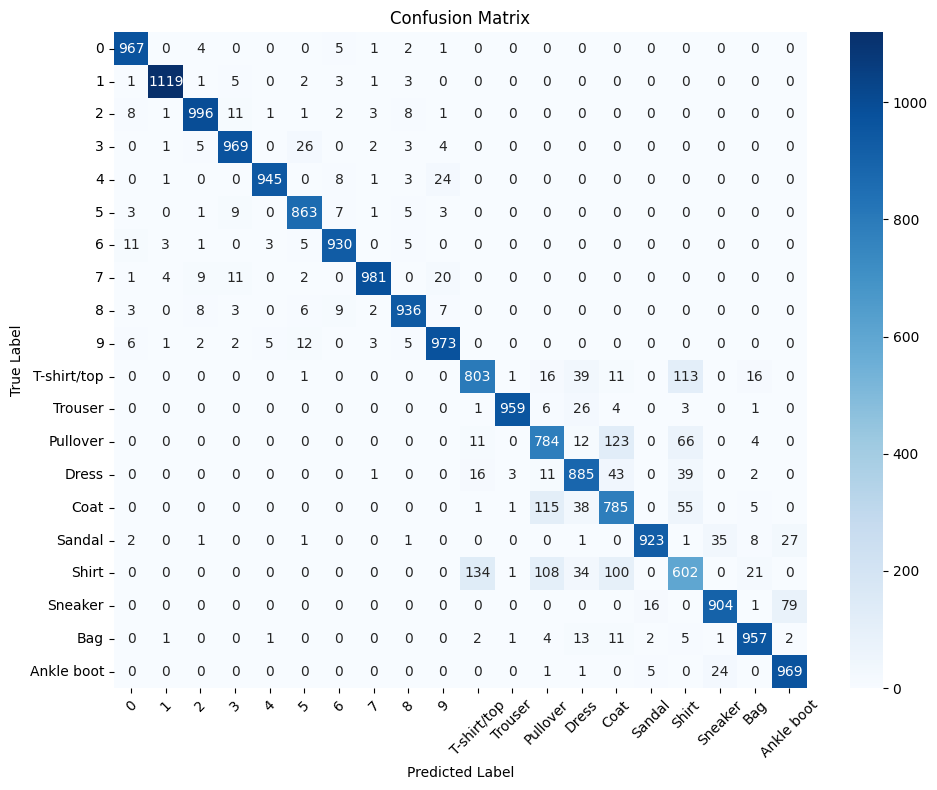

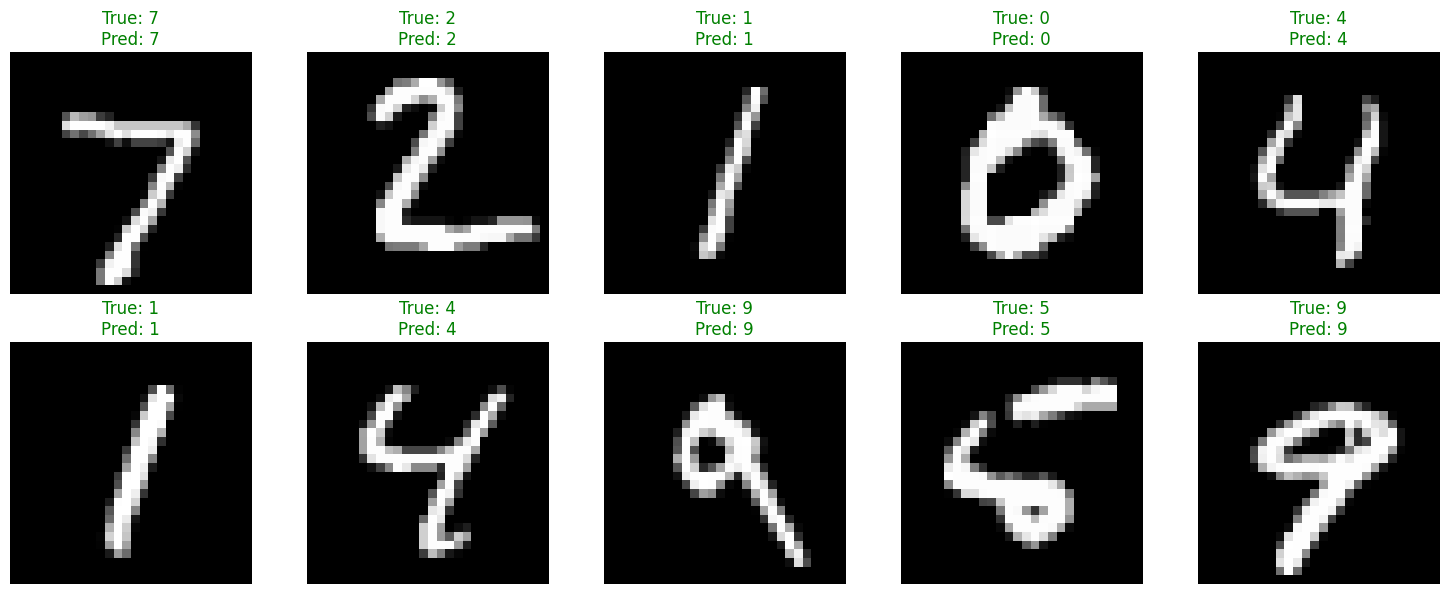

In [ ]:
# Load best model
checkpoint = torch.load('checkpoints/best_model.pt')
model.load_state_dict(checkpoint['model_state_dict'])
print(f"Loaded best model from epoch {checkpoint['epoch']+1} with val acc: {checkpoint['val_acc']:.2f}%")

# Final evaluation
val_loss, val_acc = evaluate(model, val_loader, device)
print(f"Final evaluation: Loss: {val_loss:.4f}, Accuracy: {val_acc:.2f}%")

# Plot training and validation metrics
plt.figure(figsize=(12, 5))

# Plot loss
plt.subplot(1, 2, 1)
plt.plot(history['train_losses'], label='Train Loss')
plt.plot(history['val_losses'], label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()

# Plot accuracy
plt.subplot(1, 2, 2)
plt.plot(history['train_accs'], label='Train Accuracy')
plt.plot(history['val_accs'], label='Val Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.title('Training and Validation Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

# Visualize confusion matrix
from sklearn.metrics import confusion_matrix
import seaborn as sns

# Get predictions
@torch.no_grad()
def get_predictions(model, dataloader, device):
    model.eval()
    all_preds = []
    all_targets = []

    for images, targets in dataloader:
        images = images.to(device)

        # Forward pass
        logits, _ = model(images)
        preds = torch.argmax(logits, dim=1)

        all_preds.extend(preds.cpu().numpy())
        all_targets.extend(targets.numpy())

    return np.array(all_preds), np.array(all_targets)

# Get predictions and targets
val_preds, val_targets = get_predictions(model, val_loader, device)

# Create confusion matrix
cm = confusion_matrix(val_targets, val_preds)

# Plot confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Visualize some predictions
def visualize_predictions(model, dataloader, class_names, num_samples=10, device=device):
    # Get batch
    data_iter = iter(dataloader)
    images, targets = next(data_iter)
    images = images[:num_samples].to(device)
    targets = targets[:num_samples]

    # Get predictions
    model.eval()
    with torch.no_grad():
        logits, _ = model(images)
        probs = F.softmax(logits, dim=1)
        preds = torch.argmax(logits, dim=1).cpu()

    # Plot
    fig, axes = plt.subplots(2, 5, figsize=(15, 6))
    axes = axes.flatten()

    for i in range(num_samples):
        # Plot image
        img = images[i].cpu().squeeze().numpy()
        ax = axes[i]
        ax.imshow(img, cmap='gray')

        # Set title color based on correctness
        correct = preds[i] == targets[i]
        color = 'green' if correct else 'red'

        # Add prediction info
        ax.set_title(f"True: {class_names[targets[i]]}\nPred: {class_names[preds[i]]}",
                    color=color)
        ax.axis('off')

    plt.tight_layout()
    plt.show()

# Visualize predictions
visualize_predictions(model, val_loader, class_names)

## 8. Conclusion and Analysis


Classification Report:
              precision    recall  f1-score   support

           0       0.97      0.99      0.98       980
           1       0.99      0.99      0.99      1135
           2       0.97      0.97      0.97      1032
           3       0.96      0.96      0.96      1010
           4       0.99      0.96      0.98       982
           5       0.94      0.97      0.95       892
           6       0.96      0.97      0.97       958
           7       0.98      0.95      0.97      1028
           8       0.96      0.96      0.96       974
           9       0.94      0.96      0.95      1009
 T-shirt/top       0.83      0.80      0.82      1000
     Trouser       0.99      0.96      0.98      1000
    Pullover       0.75      0.78      0.77      1000
       Dress       0.84      0.89      0.86      1000
        Coat       0.73      0.79      0.76      1000
      Sandal       0.98      0.92      0.95      1000
       Shirt       0.68      0.60      0.64      1000
    

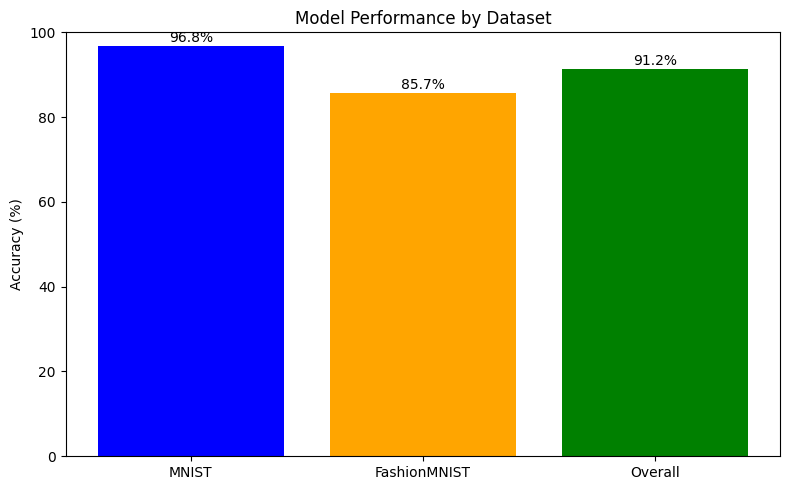

Vision-nanoGPT Model Summary
Model Architecture: VisionGPT with 6 layers
Number of Parameters: 4.76M
Overall Accuracy: 91.25%
MNIST Accuracy: 96.79%
FashionMNIST Accuracy: 85.71%
--------------------------------------------------
Vision-nanoGPT successfully adapts the nanoGPT architecture
for image classification by using patch embeddings and a
CLS token approach, inspired by I-JEPA methodology.
Model saved to vision_nanogpt_model.pt


In [ ]:
# Model performance summary
from sklearn.metrics import classification_report

# Generate classification report
report = classification_report(val_targets, val_preds, target_names=class_names)
print("Classification Report:")
print(report)

# Analyze performance by dataset
# Assuming first 10 classes (0-9) are MNIST, rest (10-19) are FashionMNIST
mnist_mask = val_targets < 10
fashion_mask = val_targets >= 10

mnist_acc = 100 * np.mean(val_preds[mnist_mask] == val_targets[mnist_mask])
fashion_acc = 100 * np.mean(val_preds[fashion_mask] == val_targets[fashion_mask])

print(f"MNIST Accuracy: {mnist_acc:.2f}%")
print(f"FashionMNIST Accuracy: {fashion_acc:.2f}%")

# Plot performance comparison
labels = ['MNIST', 'FashionMNIST', 'Overall']
accuracies = [mnist_acc, fashion_acc, val_acc]

plt.figure(figsize=(8, 5))
plt.bar(labels, accuracies, color=['blue', 'orange', 'green'])
plt.ylabel('Accuracy (%)')
plt.title('Model Performance by Dataset')
plt.ylim(0, 100)

# Add value labels
for i, v in enumerate(accuracies):
    plt.text(i, v + 1, f"{v:.1f}%", ha='center')

plt.tight_layout()
plt.show()

# Summary
print("=" * 50)
print("Vision-nanoGPT Model Summary")
print("=" * 50)
print(f"Model Architecture: VisionGPT with {config.n_layer} layers")
print(f"Number of Parameters: {model.get_num_params()/1e6:.2f}M")
print(f"Overall Accuracy: {val_acc:.2f}%")
print(f"MNIST Accuracy: {mnist_acc:.2f}%")
print(f"FashionMNIST Accuracy: {fashion_acc:.2f}%")
print("-" * 50)
print("Vision-nanoGPT successfully adapts the nanoGPT architecture")
print("for image classification by using patch embeddings and a")
print("CLS token approach, inspired by I-JEPA methodology.")
print("=" * 50)

# Save model for future use
torch.save({
    'model_state_dict': model.state_dict(),
    'config': vars(config),
    'class_names': class_names
}, 'vision_nanogpt_model.pt')

print("Model saved to vision_nanogpt_model.pt")